In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from pathlib import Path

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy import stats

from sklearn.linear_model import LinearRegression, LogisticRegression
from xgboost import XGBRegressor, plot_importance
from sklearn import tree

from sklearn.metrics import (
    mean_squared_error,
    r2_score,
    accuracy_score,
    classification_report,
    confusion_matrix,
)

plt.style.use("fivethirtyeight")

I picked up a concept from the book Hands-on ML, where the author defined a function to save figures generated by the code in high-res.

In [ ]:
IMAGES_PATH = Path() / "images" / "classification"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

### Loading Data

In [3]:
data = pd.read_csv("../data/raw/Ecommerce_Consumer_Behavior_Analysis_Data.csv")
data.head()

,Customer_ID,Age,Gender,Income_Level,Marital_Status,Education_Level,Occupation,Location,Purchase_Category,Purchase_Amount,...,Customer_Satisfaction,Engagement_with_Ads,Device_Used_for_Shopping,Payment_Method,Time_of_Purchase,Discount_Used,Customer_Loyalty_Program_Member,Purchase_Intent,Shipping_Preference,Time_to_Decision
0,37-611-6911,22,Female,Middle,Married,Bachelor's,Middle,Évry,Gardening & Outdoors,$333.80,...,7,NaN,Tablet,Credit Card,3/1/2024,True,False,Need-based,No Preference,2
1,29-392-9296,49,Male,High,Married,High School,High,Huocheng,Food & Beverages,$222.22,...,5,High,Tablet,PayPal,4/16/2024,True,False,Wants-based,Standard,6
2,84-649-5117,24,Female,Middle,Single,Master's,High,Huzhen,Office Supplies,$426.22,...,7,Low,Smartphone,Debit Card,3/15/2024,True,True,Impulsive,No Preference,3
3,48-980-6078,29,Female,Middle,Single,Master's,Middle,Wiwilí,Home Appliances,$101.31,...,1,NaN,Smartphone,Other,10/4/2024,True,True,Need-based,Express,10
4,91-170-9072,33,Female,Middle,Widowed,High School,Middle,Nara,Furniture,$211.70,...,10,NaN,Smartphone,Debit Card,1/30/2024,False,False,Wants-based,No Preference,4


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 28 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Customer_ID                            1000 non-null   object 
 1   Age                                    1000 non-null   int64  
 2   Gender                                 1000 non-null   object 
 3   Income_Level                           1000 non-null   object 
 4   Marital_Status                         1000 non-null   object 
 5   Education_Level                        1000 non-null   object 
 6   Occupation                             1000 non-null   object 
 7   Location                               1000 non-null   object 
 8   Purchase_Category                      1000 non-null   object 
 9   Purchase_Amount                        1000 non-null   object 
 10  Frequency_of_Purchase                  1000 non-null   int64  
 11  Purch

In [5]:
data.describe()

,Age,Frequency_of_Purchase,Brand_Loyalty,Product_Rating,Time_Spent_on_Product_Research(hours),Return_Rate,Customer_Satisfaction,Time_to_Decision
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,34.304000,6.945000,3.026000,3.033000,1.013030,0.954000,5.399000,7.547000
std,9.353238,3.147361,1.416803,1.436654,0.791802,0.810272,2.868454,4.035849
min,18.000000,2.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
25%,26.000000,4.000000,2.000000,2.000000,0.000000,0.000000,3.000000,4.000000
50%,34.500000,7.000000,3.000000,3.000000,1.000000,1.000000,5.000000,8.000000
75%,42.000000,10.000000,4.000000,4.000000,2.000000,2.000000,8.000000,11.000000
max,50.000000,12.000000,5.000000,5.000000,2.000000,2.000000,10.000000,14.000000


### Data Cleaning

In [6]:
col_to_categorical = [
    "Gender",
    "Income_Level",
    "Marital_Status",
    "Education_Level",
    "Occupation",
    "Purchase_Channel",
    "Social_Media_Influence",
    "Discount_Sensitivity",
    "Engagement_with_Ads",
    "Device_Used_for_Shopping",
    "Payment_Method",
    "Purchase_Intent",
    "Shipping_Preference",
    "Purchase_Category",
]
for col in col_to_categorical:
    data[col] = data[col].astype("category")

In [7]:
# Looking at data.info() and checking against data, 'Purchase_Amount' could be converted to a float
data["Purchase_Amount"] = data["Purchase_Amount"].str.replace("$", "").astype(float)

In [8]:
# convert to datatime
data["Time_of_Purchase"] = pd.to_datetime(data["Time_of_Purchase"], errors="coerce")

In [9]:
assert not data.duplicated(subset="Customer_ID").any()

In [10]:
z_scores = np.abs(stats.zscore(data.select_dtypes(include=np.number)))
print(f"There are a total of {data[(z_scores > 3).all(axis = 1)].shape[0]} outliers")
print(f"There are a total of {data.duplicated().sum()} duplicated row(s)")

There are a total of 0 outliers
There are a total of 0 duplicated row(s)


In [11]:
for col in data.columns:
    if data[col].isnull().sum() > 0:
        print(f"{col} has {data[col].isnull().sum()} null values")

print("---Handling missing values---")
imputer = SimpleImputer(strategy="most_frequent")

data[["Social_Media_Influence", "Engagement_with_Ads"]] = imputer.fit_transform(
    data[["Social_Media_Influence", "Engagement_with_Ads"]]
)

print(
    f"Total number of columns with missing values after clean up: {data.isnull().any().sum()}"
)

Social_Media_Influence has 247 null values
Engagement_with_Ads has 256 null values
---Handling missing values---
Total number of columns with missing values after clean up: 0


### Exploratory Data Analysis (EDA)

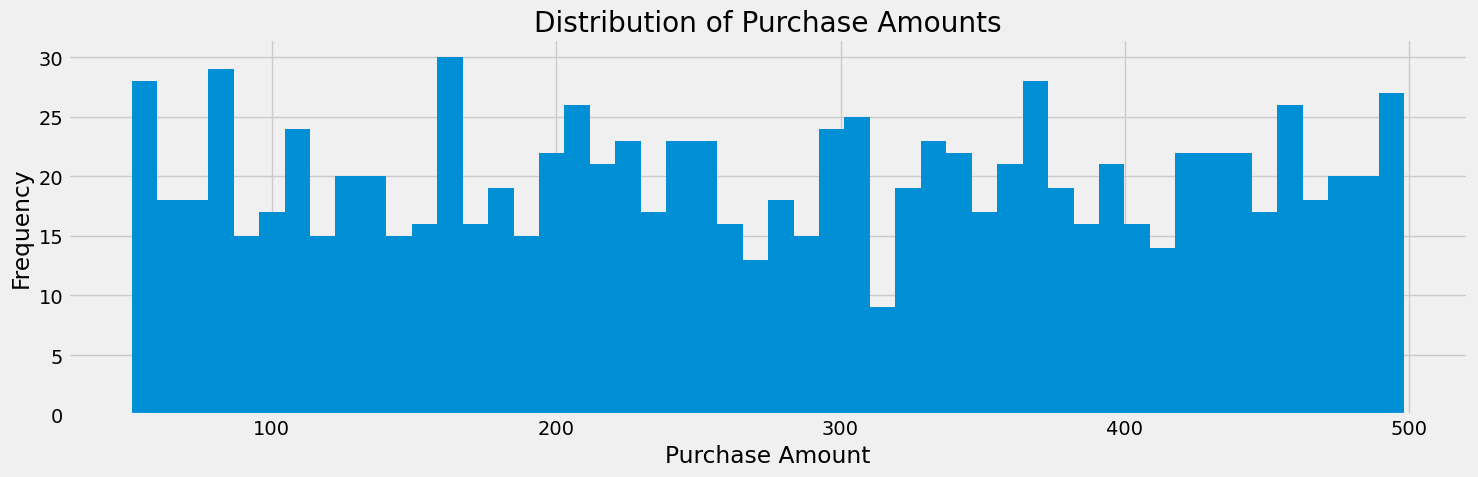

In [12]:
# Distribution of Purchase Amounts
plt.figure(figsize=(15, 5))
plt.hist(data["Purchase_Amount"], bins=50) 
plt.title("Distribution of Purchase Amounts")
plt.xlabel("Purchase Amount")
plt.ylabel("Frequency")
save_fig("Distribution of Purchase Amounts")
plt.show()

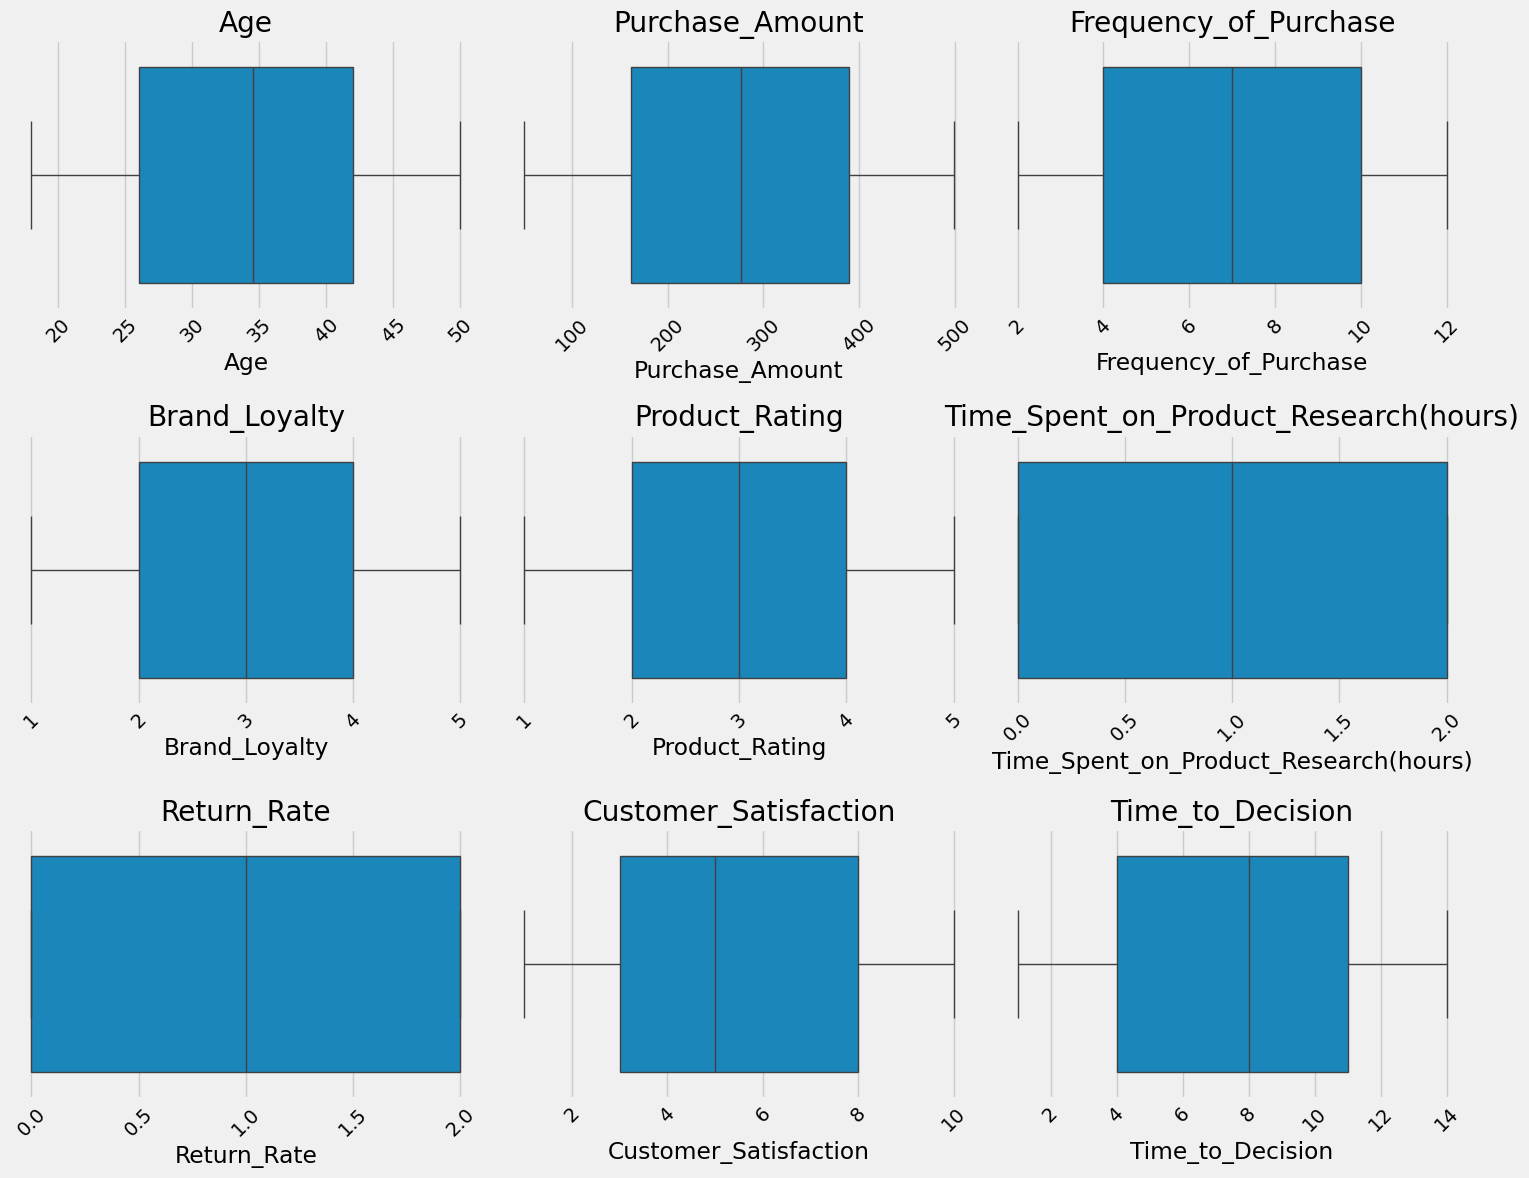

In [13]:
# Distribution of Numerical Features
numerical_cols = data.select_dtypes(include=np.number).columns

n_cols = 3
n_features = len(numerical_cols)
n_rows = math.ceil(n_features / n_cols)

plt.figure(figsize=(5 * n_cols, 4 * n_rows))  # dynamic figure size

for i, col in enumerate(numerical_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.boxplot(x=data[col])  # optional color
    plt.title(col)
    plt.xticks(rotation=45)

# Hide any unused subplots
for j in range(i + 1, n_rows * n_cols + 1):
    plt.subplot(n_rows, n_cols, j)
    plt.axis('off')

plt.tight_layout()
save_fig("Distribution of Numerical Features")
plt.show()


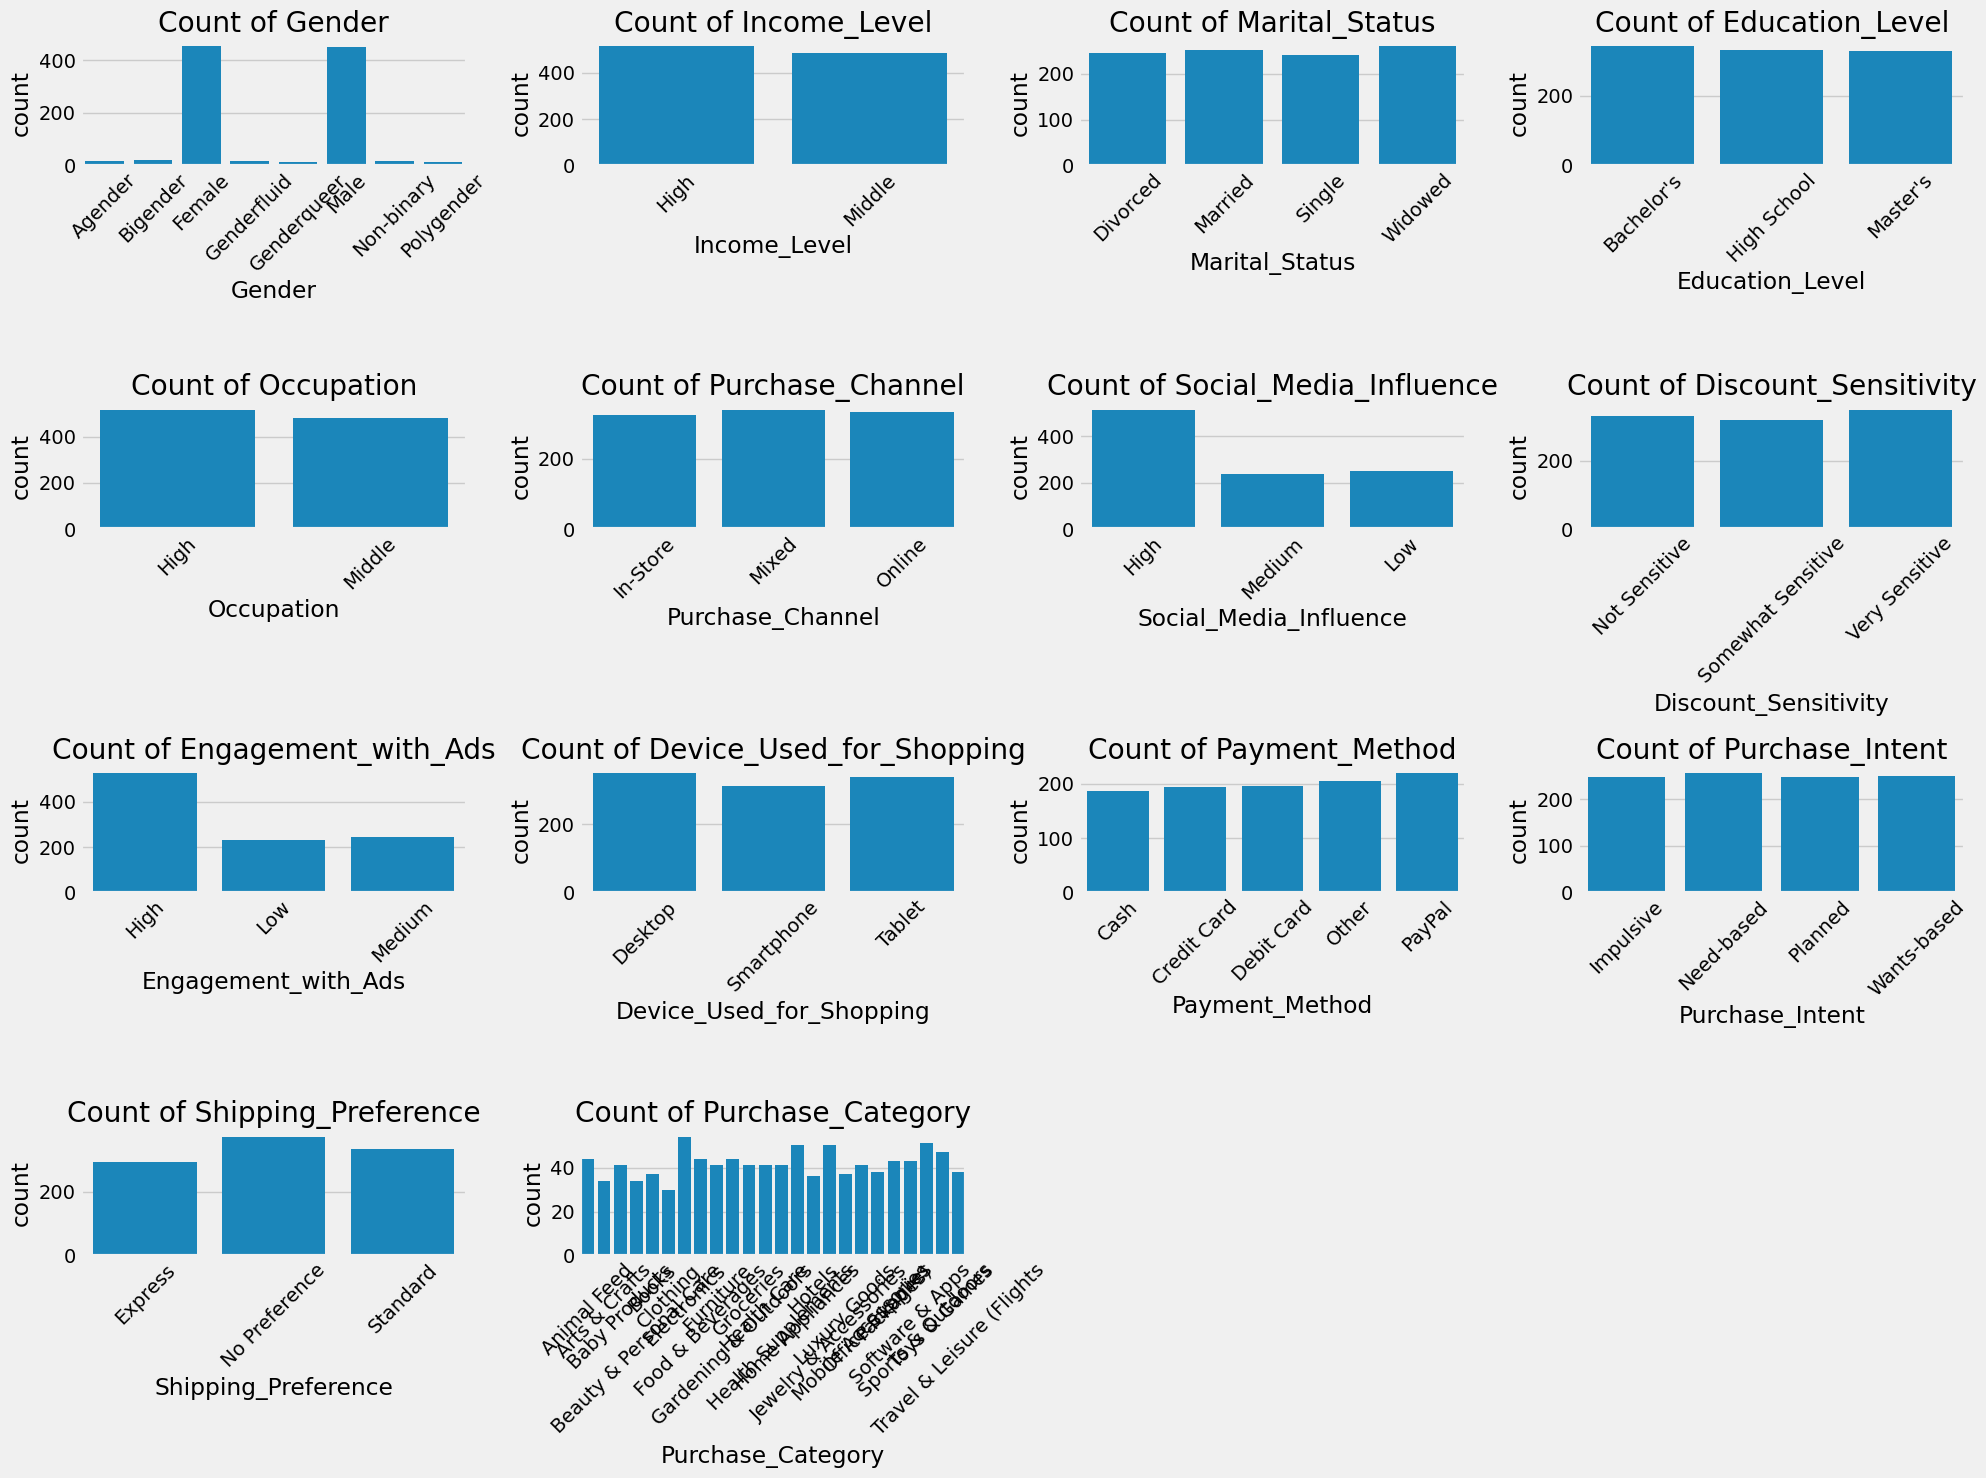

In [14]:
plt.figure(figsize=(20, 15))
for i, col in enumerate(col_to_categorical):
    plt.subplot(4, 4, i + 1)
    sns.countplot(x=data[col])
    plt.title(f"Count of {col}")
    plt.xticks(rotation=45)
plt.tight_layout()
save_fig("Distribution of Categorical Features")
plt.show()

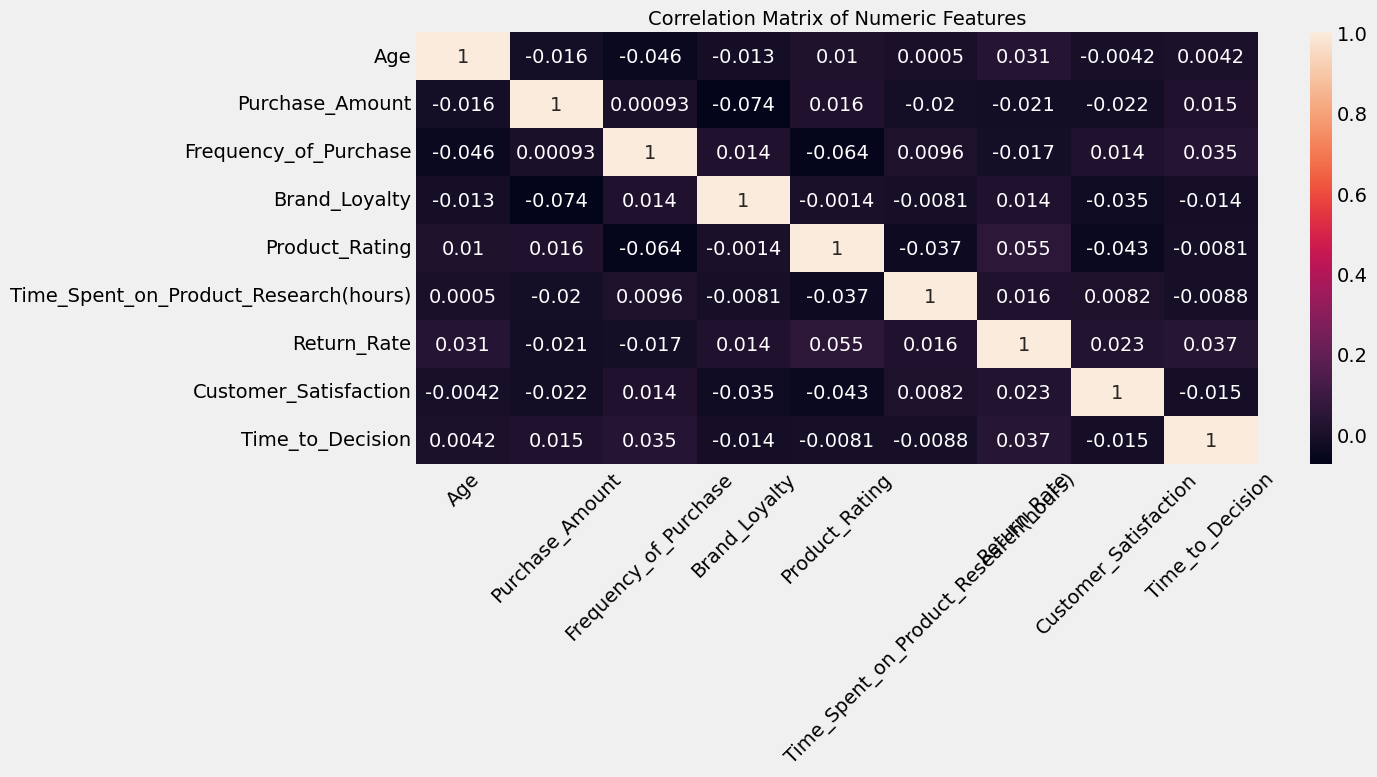

In [15]:
plt.figure(figsize=(15, 8))
sns.heatmap(
    data[numerical_cols].corr(),
    annot=True,
)
plt.title("Correlation Matrix of Numeric Features", fontsize=14)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()

save_fig("Correlation Matrix of Numeric Features")
plt.show()

There are no highly correlated columns so no need to drop any to avoid multi collinearity. 

### Data Transformation & Feature Engineering

In [16]:
# Drop irrelevant columns
object_cols = data.select_dtypes(include=["object", "datetime64[ns]"]).columns.tolist()
data = data.drop(object_cols, axis=1)

# Categorical feature counts
string_cols = data.select_dtypes(include=["category"]).columns.tolist()

# One-hot encode categorical features
cols_to_onehot = data[string_cols].columns.tolist()
data = pd.get_dummies(data, columns=cols_to_onehot, drop_first=True)
print("Categorical columns have been one-hot encoded.")

Categorical columns have been one-hot encoded.


### Regression Analysis: Predicting Purchase_Amount

In [17]:
X_reg = data.drop("Purchase_Amount", axis=1)
y_reg = data["Purchase_Amount"]

# Split data
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

# Scale numerical features (excluding the target)
numeric_features_reg = X_train_reg.select_dtypes(include=np.number).columns.tolist()

scaler = StandardScaler()

X_train_reg[numeric_features_reg] = scaler.fit_transform(
    X_train_reg[numeric_features_reg]
)

X_test_reg[numeric_features_reg] = scaler.transform(X_test_reg[numeric_features_reg])
print("Data split into training and testing sets for regression.")

Data split into training and testing sets for regression.


##### Linear Regression

In [18]:
# Linear Regression Model
reg = LinearRegression()
reg.fit(X_train_reg, y_train_reg)
y_pred_reg_lin = reg.predict(X_test_reg)

mse_lin = mean_squared_error(y_test_reg, y_pred_reg_lin)
rmse_lin = np.sqrt(mse_lin)
r2_lin = r2_score(y_test_reg, y_pred_reg_lin)
print(
    f"Linear Regression | MSE: {mse_lin:.2f}, RMSE: {rmse_lin:.2f}",
    f"Linear Regression | r2: {r2_lin:.2f}, RMSE: {r2_lin:.2f}"
)  # Linear Regression | MSE: 18819.68, RMSE: 137.18 | r2: -0.08, RMSE: -0.08

Linear Regression | MSE: 18804.77, RMSE: 137.13 Linear Regression | r2: -0.08, RMSE: -0.08


In [19]:
feature_importance = pd.DataFrame({
    'feature': X_train_reg.columns,
    'coefficient': reg.coef_
})

# Sort by absolute value to see the most influential
feature_importance['abs_coef'] = feature_importance['coefficient'].abs()
feature_importance = feature_importance.sort_values(by='abs_coef', ascending=False)
print(feature_importance)


                                feature  coefficient    abs_coef
16                    Gender_Polygender   108.061436  108.061436
12                   Gender_Genderfluid    84.677550   84.677550
43    Purchase_Category_Software & Apps    79.527254   79.527254
27              Purchase_Category_Books    78.369784   78.369784
11                        Gender_Female    75.915471   75.915471
..                                  ...          ...         ...
9                      Time_to_Decision    -1.232334    1.232334
0                                   Age    -1.100099    1.100099
24      Purchase_Category_Arts & Crafts    -0.672856    0.672856
21          Education_Level_High School    -0.451633    0.451633
50  Discount_Sensitivity_Very Sensitive    -0.160624    0.160624

[62 rows x 3 columns]


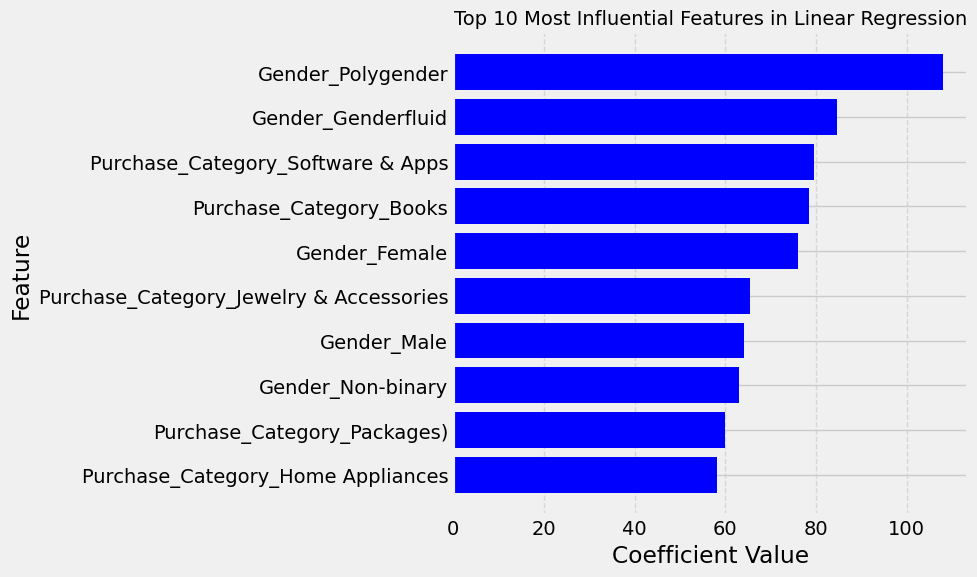

In [20]:
# Take top 10 by absolute coefficient
top_features = feature_importance.head(10)

plt.figure(figsize=(10, 6))
colors = ['blue' if c > 0 else 'red' for c in top_features['coefficient']]
plt.barh(top_features['feature'], top_features['coefficient'], color=colors)
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.title("Top 10 Most Influential Features in Linear Regression", fontsize=14)
plt.gca().invert_yaxis()  # Largest at top
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()

save_fig("Top 10 Most Influential Features in Linear Regression")
plt.show()


##### XGBRegressor

In [21]:
# XGBoost Regression Model
xgbreg = XGBRegressor(n_estimators=200, learning_rate=0.1, random_state=42)
xgbreg.fit(X_train_reg, y_train_reg)
y_pred_reg_xgb = xgbreg.predict(X_test_reg)
mse_xgb = mean_squared_error(y_test_reg, y_pred_reg_xgb)
rmse_xgb = np.sqrt(mse_xgb)
r2_xgb = r2_score(y_test_reg, y_pred_reg_xgb)

print(
    f"XGBoost Regression | MSE: {mse_xgb:.2f}, RMSE: {rmse_xgb:.2f}, r2score: {r2_xgb:.2f}"
)  # XGBoost Regression | MSE: 22890.67, RMSE: 151.30, r2score: -0.32

XGBoost Regression | MSE: 23040.82, RMSE: 151.79, r2score: -0.32


In [22]:
importance_dict = xgbreg.get_booster().get_score(importance_type='weight')

# Convert to DataFrame
feature_importance_xgb = pd.DataFrame({
    'feature': list(importance_dict.keys()),
    'importance': list(importance_dict.values())
})

# Sort by importance
feature_importance_xgb = feature_importance_xgb.sort_values(by='importance', ascending=False)
print(feature_importance_xgb.head(10))

                                  feature  importance
0                                     Age      1545.0
1                   Frequency_of_Purchase       724.0
6                   Customer_Satisfaction       551.0
9                        Time_to_Decision       487.0
3                          Product_Rating       405.0
2                           Brand_Loyalty       360.0
4   Time_Spent_on_Product_Research(hours)       290.0
5                             Return_Rate       207.0
61           Shipping_Preference_Standard       127.0
18                 Marital_Status_Married       119.0


<Figure size 1000x800 with 0 Axes>

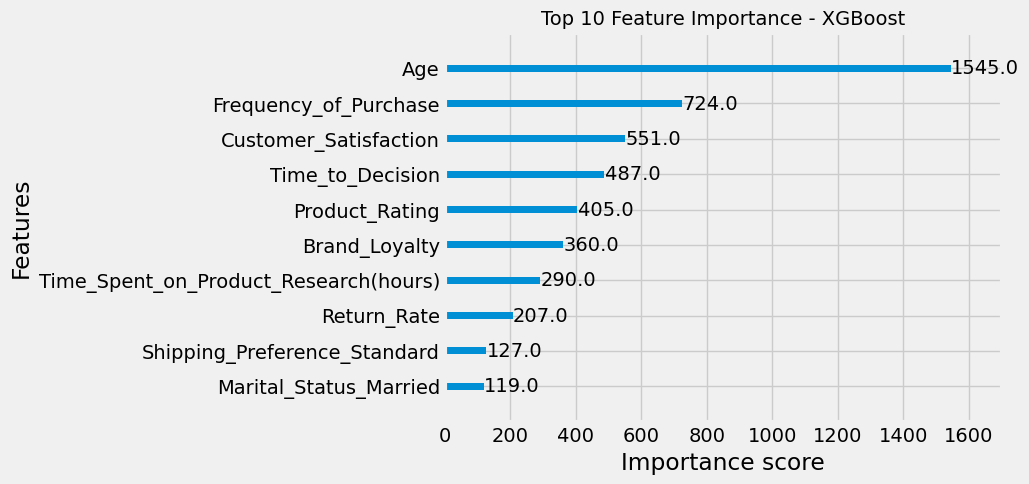

In [23]:
plt.figure(figsize=(10,8))
plot_importance(
    xgbreg, 
    max_num_features=10, 
    importance_type='weight'
)
plt.title("Top 10 Feature Importance - XGBoost", fontsize=14)
save_fig("Top 10 Feature Importance - XGBoost", tight_layout=False)
plt.show()

### Classification Analysis: Predicting Customer_Satisfaction

In [24]:
# The target variable `Customer_Satisfaction` must be left unscaled
X_clf = data.drop("Customer_Satisfaction", axis=1)
y_clf = data["Customer_Satisfaction"]

# Scale numerical features (excluding the target)
scaler_clf = StandardScaler()
numeric_features_clf = X_clf.select_dtypes(include=np.number).columns.tolist()
X_clf[numeric_features_clf] = scaler_clf.fit_transform(
    X_clf[numeric_features_clf]
)

# Split data
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_clf, y_clf, test_size=0.2, random_state=42, stratify=y_clf
)
print("Data split into training and testing sets for classification.")

Data split into training and testing sets for classification.


#### Logistic Regression

In [25]:
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_clf, y_train_clf)
y_pred_clf_log = logreg.predict(X_test_clf)

acc_log = accuracy_score(y_test_clf, y_pred_clf_log)
report = classification_report(y_test_clf, y_pred_clf_log)
conf_matrix = confusion_matrix(y_test_clf, y_pred_clf_log)

print("=== Logistic Regression Evaluation ===")
print(f"Accuracy: {acc_log:.4f}\n")
print("Classification Report:")
print(report)
print("Confusion Matrix:")
print(conf_matrix)

=== Logistic Regression Evaluation ===
Accuracy: 0.0900

Classification Report:
              precision    recall  f1-score   support

           1       0.04      0.05      0.04        22
           2       0.11      0.15      0.12        20
           3       0.04      0.05      0.05        21
           4       0.10      0.10      0.10        20
           5       0.12      0.12      0.12        17
           6       0.05      0.05      0.05        22
           7       0.11      0.10      0.10        20
           8       0.09      0.10      0.09        20
           9       0.20      0.14      0.17        21
          10       0.08      0.06      0.07        17

    accuracy                           0.09       200
   macro avg       0.09      0.09      0.09       200
weighted avg       0.09      0.09      0.09       200

Confusion Matrix:
[[1 2 2 6 1 1 4 2 1 2]
 [3 3 0 3 1 5 0 0 3 2]
 [3 5 1 1 2 3 0 3 2 1]
 [3 3 3 2 3 3 0 2 0 1]
 [2 1 5 1 2 1 1 3 1 0]
 [2 2 4 2 2 1 4 1 4 0]
 [2 4

In [26]:
# Decision Tree Classifier
clf_tree = tree.DecisionTreeClassifier(random_state=42)
clf_tree.fit(X_train_clf, y_train_clf)
y_pred_clf_tree = clf_tree.predict(X_test_clf)

acc_tree = accuracy_score(y_test_clf, y_pred_clf_tree)
report_tree = classification_report(y_test_clf, y_pred_clf_tree)
conf_matrix_tree = confusion_matrix(y_test_clf, y_pred_clf_tree)

print("=== Decision Tree Classifier Evaluation ===")
print(f"Accuracy: {acc_tree:.4f}\n")
print("Classification Report:")
print(report_tree)
print("Confusion Matrix:")
print(conf_matrix_tree)

=== Decision Tree Classifier Evaluation ===
Accuracy: 0.0900

Classification Report:
              precision    recall  f1-score   support

           1       0.10      0.09      0.10        22
           2       0.07      0.05      0.06        20
           3       0.11      0.14      0.12        21
           4       0.10      0.10      0.10        20
           5       0.06      0.06      0.06        17
           6       0.08      0.09      0.09        22
           7       0.20      0.20      0.20        20
           8       0.00      0.00      0.00        20
           9       0.05      0.05      0.05        21
          10       0.14      0.12      0.13        17

    accuracy                           0.09       200
   macro avg       0.09      0.09      0.09       200
weighted avg       0.09      0.09      0.09       200

Confusion Matrix:
[[2 0 3 3 0 1 4 2 3 4]
 [2 1 2 2 3 3 3 1 2 1]
 [3 2 3 3 0 3 1 3 3 0]
 [4 1 3 2 2 1 1 4 2 0]
 [2 2 1 2 1 1 3 2 3 0]
 [0 2 4 3 2 2 0 2 4 3]
